# 1. Load the dataset

### Load the dataset here. The dataset should be combined into a single dataframe with the 'text' columns and 'label' column as 2 of the columns included in the dataframe.

In [7]:
import pandas as pd
import json

GPT = []
HUM = []

for i in range(1,4):
    with open(f'dataset/UnSeenTesting/CS_Task{i}/gpt.json', 'r') as gpt_file:
        gpt = json.load(gpt_file)
    with open(f'dataset/UnSeenTesting/CS_Task{i}/hum.json', 'r') as hum_file:
        hum = json.load(hum_file)

    gpt = pd.DataFrame(list(gpt.items()), columns=['Paper ID', 'text'])
    hum = pd.DataFrame(list(hum.items()), columns=['Paper ID', 'text'])
    GPT.append(gpt)
    HUM.append(hum)

GPT = pd.concat(GPT, ignore_index=True)
HUM = pd.concat(HUM, ignore_index=True)

GPT['label'] = 1
HUM['label'] = 0

combined_df = pd.concat([GPT, HUM], ignore_index=True)
# sampling combined_df to have 100 rows
combined_df = combined_df.sample(n=1000, random_state=1)
combined_df.head()

,Paper ID,text,label
205179,1909.05189,"In this paper, we describe ORES: an algorithmi...",0
101710,1402.0344,This academic paper discusses the various uses...,1
89106,cs/0106009,The paper demonstrates the usefulness of model...,1
193046,1710.06500,Chain reduction enables reduced ordered binary...,0
99093,2110.15586,The proposed encryption method utilizes the se...,1


# 2. Load the model and tokenizer

In [8]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
import pandas as pd
import numpy as np

# Define the tokenizer and model for feature extraction
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

def extract_features(text):
    tokenized_text = tokenizer.encode(text, truncation=True, max_length=512, return_tensors="pt")
    outputs = model(tokenized_text)
    last_hidden_states = outputs.last_hidden_state
    TClassification = last_hidden_states[:, 0, :].squeeze().detach().numpy()
    return TClassification

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# Define the MLP architecture (it should be the same as the one you trained)
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 2)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

mlp_model = MLP(768)  # Hidden State is 768 of size for roberta-base
mlp_model.load_state_dict(torch.load('model/RobertaSentinel.pth'))
mlp_model.eval()

MLP(
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (gelu): GELU(approximate='none')
)

# 3. Extract features and Apply the model

In [10]:
# Extract features
combined_df['features'] = combined_df['text'].apply(extract_features)

# Convert extracted features to a format suitable for PyTorch
X = np.array(combined_df['features'].tolist())

# Make predictions
with torch.no_grad():
    inputs = torch.tensor(X).float()
    outputs = mlp_model(inputs)
    _, predicted = torch.max(outputs, 1)

combined_df['predicted'] = predicted.numpy()

print(combined_df[['Paper ID', 'text', 'label', 'predicted']].head(10))

          Paper ID                                               text  label  \
205179  1909.05189  In this paper, we describe ORES: an algorithmi...      0   
101710   1402.0344  This academic paper discusses the various uses...      1   
89106   cs/0106009  The paper demonstrates the usefulness of model...      1   
193046  1710.06500  Chain reduction enables reduced ordered binary...      0   
99093   2110.15586  The proposed encryption method utilizes the se...      1   
105506  1510.06788  The current state of software interfaces can b...      1   
298780  1708.09401  In this Letter we supervisedly train neural ne...      0   
44748   1710.00273  This paper explores the linguistic markers of ...      1   
288650   1302.6666  The mean occupancy rates of personal vehicle t...      0   
55207   1911.08964  We first show that \textsc{Mixed Dominating Se...      1   

        predicted  
205179          1  
101710          1  
89106           1  
193046          1  
99093           1  

# 4. Evaluate the Model

Accuracy: 0.48
Precision: 0.48
Recall: 1.00
F1 Score: 0.65
False Positive Rate (FPR): 0.99
False Negative Rate (FNR): 0.00
Confusion Matrix:
[[  4 521]
 [  0 475]]


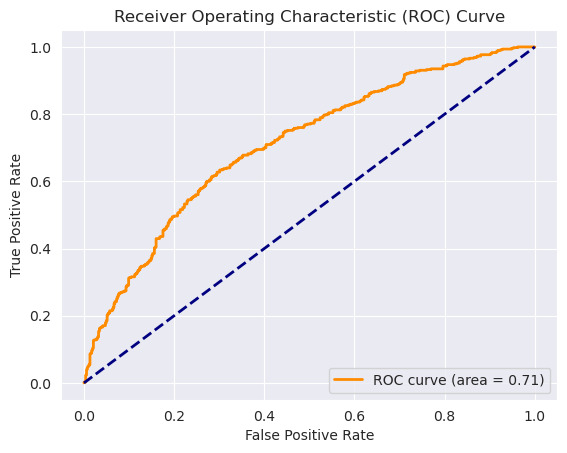

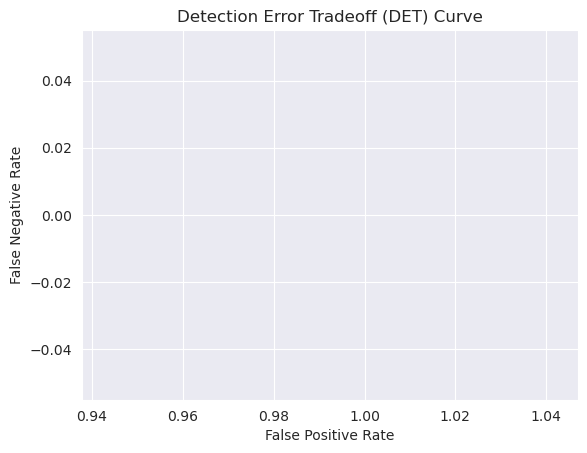

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Assuming true_labels contain the true labels and predicted_labels contain the predictions
true_labels = combined_df['label'].tolist()
predicted_labels = combined_df['predicted'].tolist()

# Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"False Negative Rate (FNR): {fnr:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

# ROC Curve & AUC
probabilities = F.softmax(outputs, dim=1)[:, 1].numpy()
fpr_roc, tpr_roc, _ = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr_roc, tpr_roc)

plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# DET Curve
plt.figure()
plt.plot(fpr, fnr, color='darkorange', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.title('Detection Error Tradeoff (DET) Curve')
plt.show()

In [12]:
print()